In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
from scipy.ndimage import rotate, zoom
from sklearn.preprocessing import PowerTransformer
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-07 06:15:19.611129: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 06:15:19.611166: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 06:15:19.611207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_feature_vectors():
    with open("feature_vecs.txt", "r") as f:
        f = f.read().split("\n\n\n")
        noun_dict = {}
        for noun_vec in f:
            split = noun_vec.split("\n\n")
            noun = split[0].split()[2][:-1]
            
            vec = split[1]
            vec = [item.strip().replace("(", "").replace(")", "") for item in vec.split(",\n")]
            vec = [(item.split()[:-1], item.split()[-1]) for item in vec]

            vec = sorted(vec, key=lambda x: x[0])
            vec = {" ".join(item[0]): float(item[1]) for item in vec}

            noun_dict[noun] = vec

    return {k: [noun_dict[k][k1] for k1 in noun_dict[k]] for k in noun_dict}


In [3]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(1)]
pickles = [item for sublist in pickles for item in sublist]
pickles = sorted(pickles, key=lambda x: x[1])

nouns = list(set([item[1] for item in pickles]))
nouns_train = nouns[:-2]
nouns_test = nouns[-2:]

feature_vectors = get_feature_vectors()
train_x = np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_train])
train_y = np.array([item[0] for item in pickles if item[1] in nouns_train])

test_x = np.array([feature_vectors[item[1]] for item in pickles if item[1] in nouns_test])
test_y = np.array([item[0] for item in pickles if item[1] in nouns_test])

print(len(train_x), len(train_y))
del pickles

347 347


In [4]:
def get_sample(train=True):
    i = random.randint(0, len(train_x) - 1)

    target, scan = train_x[i], train_y[i]
    # scan = np.expand_dims(scan, -1)
    
    return scan, target

In [5]:
def plot_scan(scan):
    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=-1, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

    plt.show()

In [6]:
def get_batch(batch_size=32, train=True):
    
    samples = list(Pool(processes=8).imap(get_sample, [train] * batch_size))
    batch_x = [sample[1] for sample in samples]
    batch_y = [sample[0] for sample in samples]

    return np.array(batch_x), np.array(batch_y)

a, b = get_batch(16)
a.shape, b.shape

((16, 25), (16, 23, 61, 51))

In [7]:
class BasisSum(Model):
    def __init__(self):
        super().__init__()
        self.basis = tf.Variable(tf.zeros((25, 23, 61, 51, 1)))

    @tf.function(reduce_retracing=True)
    def call(self, x):
        x = tf.expand_dims(x, -1)
        x = tf.einsum("ijklm,bim->bjklm", self.basis, x)
        x = tf.squeeze(x, axis=-1)
        return x

0 0.7708325386047363
1 0.7044922709465027
2 0.6290056109428406
3 0.5523625612258911
4 0.4789636731147766
5 0.41164642572402954
6 0.35215941071510315
7 0.30125799775123596
8 0.25882282853126526
9 0.22411198914051056
10 0.19606247544288635
11 0.17353887856006622
12 0.15548871457576752
13 0.14100493490695953
14 0.129343643784523
15 0.11990749090909958
16 0.11222720146179199
17 0.10593542456626892
18 0.10074896365404129
19 0.0964469313621521
20 0.09285354614257812
21 0.08983022719621658
22 0.08726834505796432
23 0.08508257567882538
24 0.08320599794387817
25 0.08158621191978455
26 0.0801805928349495
27 0.07895488291978836
28 0.07788078486919403
29 0.07693397253751755
30 0.07609592378139496
31 0.07535138726234436
32 0.07468700408935547
33 0.07409187406301498
34 0.07355602085590363
35 0.07307116687297821
36 0.07263097167015076
37 0.07223086059093475
38 0.07186628133058548
39 0.07153284549713135
40 0.07122692465782166
41 0.07094516605138779
42 0.07068509608507156
43 0.07044433802366257
44 0.07

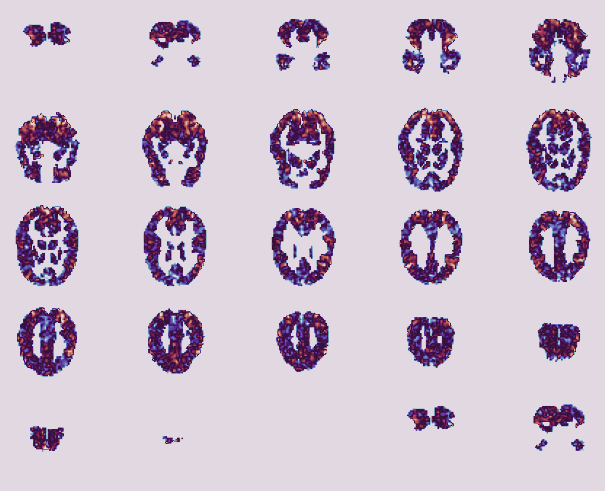

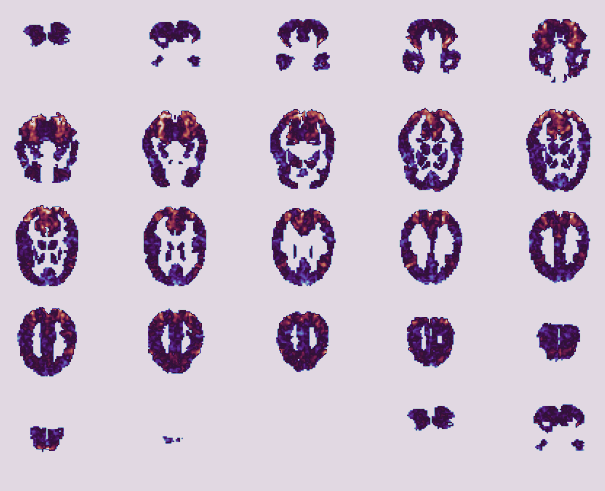

In [8]:
model = BasisSum()

loss = losses.MeanAbsoluteError()
opt = optimizers.Adam(0.1)

for i in range(1000):
    with tf.GradientTape() as tape:
        batchloss = loss(train_y, model(train_x))
        grad = tape.gradient(batchloss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))

        print(i, float(batchloss))

pred = model(test_x).numpy()
print(float(loss(test_y, pred)))

plot_scan(test_y[0])
plot_scan(pred[0])